## Installations and importations

In [175]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib ipympl
from ipynb.fs.full.triangle_matching import triangle_matching_fn

plot_no = 1

### Load images

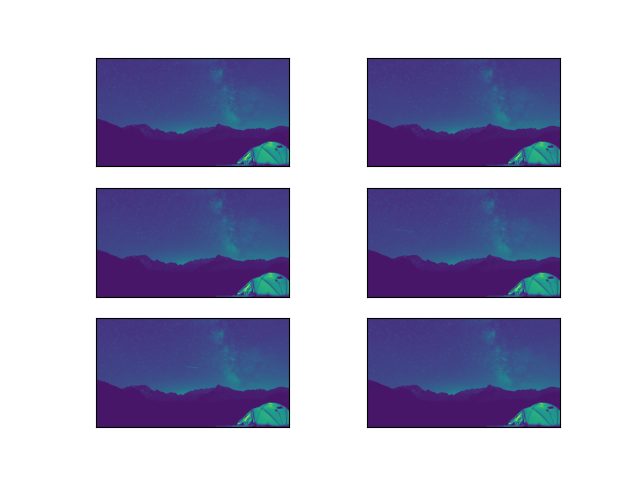

In [194]:
Image_Src_dir = 'Night_camp_images'
Image_files = os.listdir(Image_Src_dir)

IMAGES = []
for file in Image_files:
    IMAGES.append(cv2.imread(Image_Src_dir+"\\"+file))    
    IMAGES[-1] = cv2.cvtColor(IMAGES[-1], cv2.COLOR_BGR2GRAY)
    IMAGES[-1] = np.array(IMAGES[-1], dtype=np.float_)/255

# Plot(1st image)
plt.figure(plot_no)
plot_no += 1
for image_no in range(len(IMAGES)):
    plt.subplot(3,2,image_no+1)
    plt.imshow(IMAGES[image_no])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Crop images if neccessary

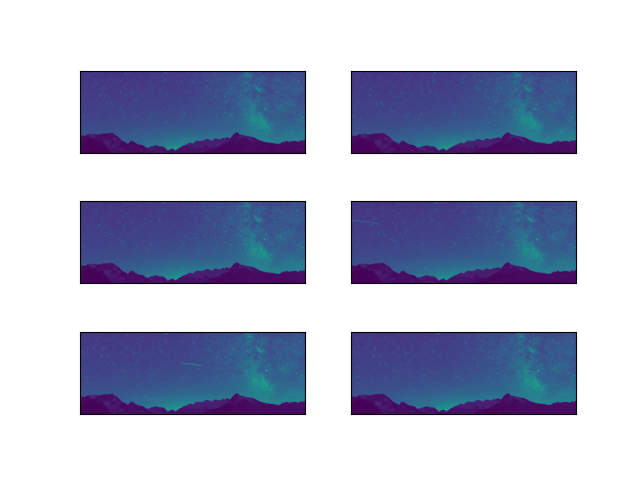

In [195]:
Crop_border_row = 300
Crop_border_col = 300
for image_no in range(len(IMAGES)):
    IMAGES[image_no] = IMAGES[image_no][Crop_border_row:IMAGES[image_no].shape[0]-Crop_border_row, Crop_border_col:IMAGES[image_no].shape[1]-Crop_border_col]

plt.figure(plot_no)
plot_no += 1
for image_no in range(len(IMAGES)):
    plt.subplot(3,2,image_no+1)
    plt.imshow(IMAGES[image_no])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Threshold

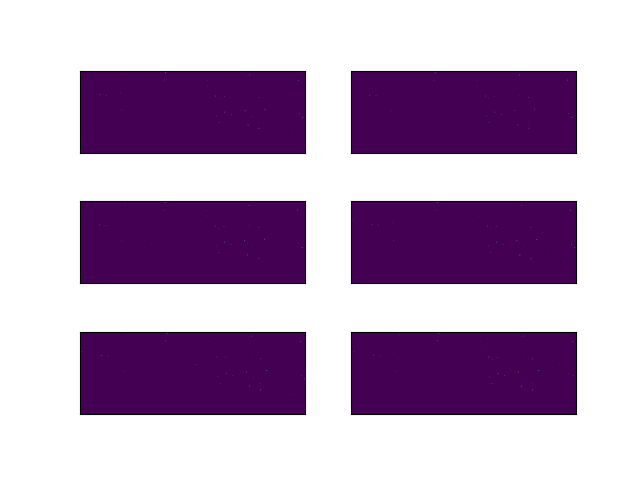

In [196]:
Threshold = 0.6
for image_no in range(len(IMAGES)):
    IMAGES[image_no][IMAGES[image_no] < Threshold] = 0

plt.figure(plot_no)
plot_no += 1
for image_no in range(len(IMAGES)):
    plt.subplot(3,2,image_no+1)
    plt.imshow(IMAGES[image_no])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Identify star locations

In [197]:
STARS = [] #Store size and location of all stars

for image_no in range(len(IMAGES)):
    print("Locating stars in Image-",image_no+1)
    image_copy = np.copy(IMAGES[image_no])

    Star_indices = np.argwhere(image_copy)
    stars = []
    while(Star_indices.shape[0] != 0):
        Rand_pos = Star_indices[random.randrange(Star_indices.shape[0])]

        Up_shift = 0
        Right_shift = 0
        Down_shift = 0
        Left_shift = 0
        #Rand_pos = np.array([615, 1689], dtype=np.int_)        
        while True:
            if(Rand_pos[0]-Up_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Up_shift = Up_shift+1
                    continue
            if(Rand_pos[1]+Right_shift != image_copy.shape[1]-1):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]+Right_shift])):
                    Right_shift = Right_shift+1
                    continue
            if(Rand_pos[0]+Down_shift != image_copy.shape[0]-1):
                if(np.any(image_copy[Rand_pos[0]+Down_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Down_shift = Down_shift+1
                    continue
            if(Rand_pos[1]-Left_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift])):
                    Left_shift = Left_shift+1
                    continue
            break

        #Find star size
        star_size = np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])

        #Find star row
        star_row = np.dot(np.array(range(Rand_pos[0]-Up_shift, Rand_pos[0]+Down_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=1))/star_size

        #Find star column    
        star_col = np.dot(np.array(range(Rand_pos[1]-Left_shift, Rand_pos[1]+Right_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=0))/star_size    

        #Add star to list
        stars.append(np.array([star_size, star_row, star_col]))

        #Remove found star
        image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1] = 0

        #New star indices
        Star_indices = np.argwhere(image_copy)
                
    #The array of all stars
    STARS.append(np.array(stars))

Locating stars in Image- 1
Locating stars in Image- 2
Locating stars in Image- 3
Locating stars in Image- 4
Locating stars in Image- 5
Locating stars in Image- 6


### Plot located stars (only image-1)

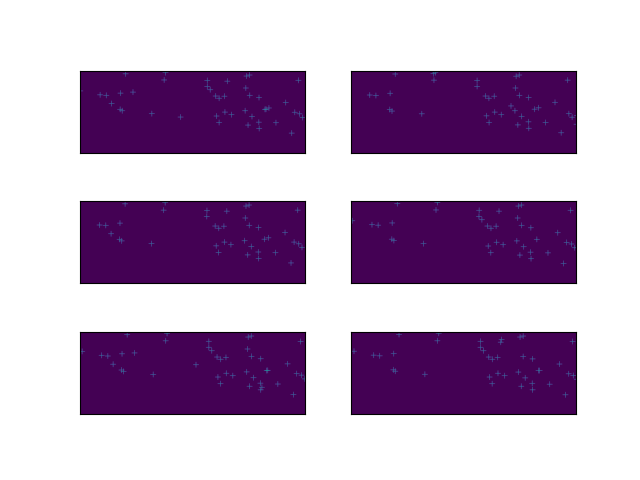

In [198]:
Plot_length = 16


plt.figure(plot_no)
plot_no += 1
for image_no in range(len(IMAGES)):
    image_copy = IMAGES[image_no].copy()
    for star in STARS[image_no]:
        image_copy[max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[0]]),  round(star[2])] = 1
        image_copy[round(star[1]), max([round(star[2])-Plot_length, 0]) : min([round(star[2])+Plot_length+1, image_copy.shape[1]])] = 1    
    plt.subplot(3,2,image_no+1)
    plt.imshow(image_copy)
    plt.xticks([])
    plt.yticks([])
plt.show()


### Sorting the stars based on size

In [199]:
for image_no in range(len(STARS)):
    STARS[image_no] = STARS[image_no][np.argsort(STARS[image_no][:,0])[::-1],:]

### Forming the triangles

In [200]:
Num_stars = 30

def Compute_dist(point1, point2):
    return np.sqrt( (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 )

TRIANGLES = []
TRIANGLE_VERTICES = []
for image_no in range(len(IMAGES)):
    stars_copy = STARS[image_no][:min([Num_stars, STARS[image_no].shape[0]]),:]
    triangles = []
    triangle_vertices = []

    Triangle_vertex_indices = np.array([0,1,2], dtype=np.int_)
    while(Triangle_vertex_indices[0]<stars_copy.shape[0]):
        Triangle_vertex_indices[1] = Triangle_vertex_indices[0]+1
        while(Triangle_vertex_indices[1]<stars_copy.shape[0]):
            Triangle_vertex_indices[2] = Triangle_vertex_indices[1]+1
            while(Triangle_vertex_indices[2]<stars_copy.shape[0]):
                


                # List of stars
                star_array = np.array([stars_copy[Triangle_vertex_indices[0],1:], stars_copy[Triangle_vertex_indices[1],1:], stars_copy[Triangle_vertex_indices[2],1:]])
                
                # Compute array of sides
                Side1 = Compute_dist(star_array[0], star_array[1])
                Side2 = Compute_dist(star_array[1], star_array[2])
                Side3 = Compute_dist(star_array[2], star_array[0])    
                Side_array = np.array([Side1, Side2, Side3])


                # Sort stars based on side order
                """
                SIDE order to STAR order
                0 1 2 --- 0 1 2
                1 0 2 --- 2 1 0
                1 2 0 --- 1 2 0
                2 1 0 --- 0 2 1
                2 0 1 --- 2 0 1
                0 2 1 --- 1 0 2
                """
                Star_sort_indices = np.argsort(Side_array)
                if( ((Star_sort_indices[1] - Star_sort_indices[0]) == -1) or ((Star_sort_indices[2] - Star_sort_indices[1]) == -1) ):
                    Star_sort_indices = np.mod(Star_sort_indices+1,3)

                # Append
                triangle_vertices.append(star_array[Star_sort_indices])
                triangles.append(np.sort(Side_array))


                Triangle_vertex_indices[2] += 1
            Triangle_vertex_indices[1] += 1
        Triangle_vertex_indices[0] += 1
    TRIANGLES.append(np.array(triangles))
    TRIANGLE_VERTICES.append(triangle_vertices)

### Triangle matching

In [201]:
SIMILARITY_MAP = triangle_matching_fn(TRIANGLES,one_to_one=False)

### Computing AFFINEs of all matched  triangles
### Then taking mode

In [215]:
Mode_bins = 500000

def compute_AFFINE(Points1, Points2):
    Mat = np.linalg.inv(np.concatenate((Points1, np.array([[1],[1],[1]])), axis=1))
    return np.reshape(Mat @ Points2, (6))

TRANSFORMS = []
for image_no in range(len(IMAGES)):
    transforms = []
    Mode = []
    
    for index in range(SIMILARITY_MAP[image_no].shape[0]):
        transforms.append(cv2.getAffineTransform(np.float32(TRIANGLE_VERTICES[image_no][index]), np.float32(TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])])).reshape((6)))
        #transforms.append(compute_AFFINE(TRIANGLE_VERTICES[image_no][index], TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])]))
    transforms = np.array(transforms)


    for index in range(6):
        dist = transforms[:,index]
        Lower_percentile = np.percentile(dist,4)
        Upper_percentile = np.percentile(dist,96)  
        dist = dist[dist<Upper_percentile]
        dist = dist[dist>Lower_percentile] 
        freq, bins = np.histogram(dist, bins=Mode_bins)

        """
        if((index == 4) and (image_no == 3)):
            plt.figure(88288)
            plt.hist(dist, Mode_bins)
            plt.show()
            waste = input("haha")
        """

        
        dummy =  (bins[np.argmax(freq)] + bins[np.argmax(freq)+1])/2
        if(index == 2):
            print(dummy)
            print(dist)
            waste = input('haha')
        dist = dist[dist<dummy+dummy/10]
        dist = dist[dist>dummy-dummy/10]
        Mode.append( np.mean(dist) )

        #Mode.append( (bins[np.argmax(freq)] + bins[np.argmax(freq)+1])/2 )
    TRANSFORMS.append(np.array(Mode))


    """
    for index in range(6):
        dist = transforms[:,index]
        Lower_percentile = np.percentile(dist,2)
        Upper_percentile = np.percentile(dist,98)
        print(image_no,index)
        dist = dist[dist<Upper_percentile]
        dist = dist[dist>Lower_percentile]
        Mode.append( np.mean(dist) )
    TRANSFORMS.append(np.array(Mode))
    """

#TRANSFORMS

-1.7049052182130395e-20
[ 0.00000000e+00 -1.03803335e-13  1.00703178e-13 ...  0.00000000e+00
 -0.00000000e+00  0.00000000e+00]
-2.751556664699251
[323.65754188 122.38428668  -1.49232961 ... 785.42981686 147.15869728
 152.49911186]


KeyboardInterrupt: Interrupted by user

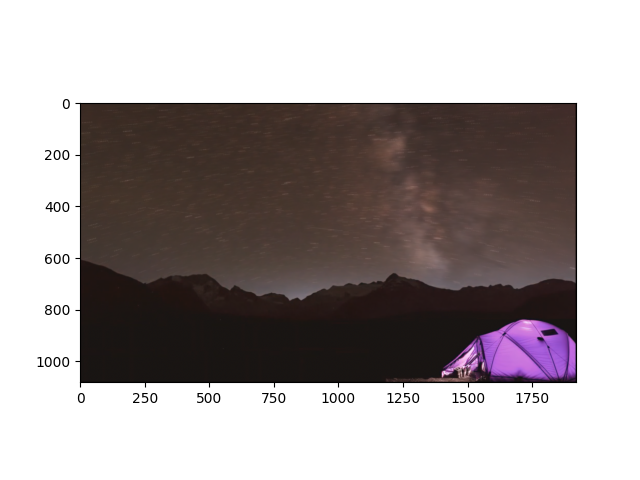

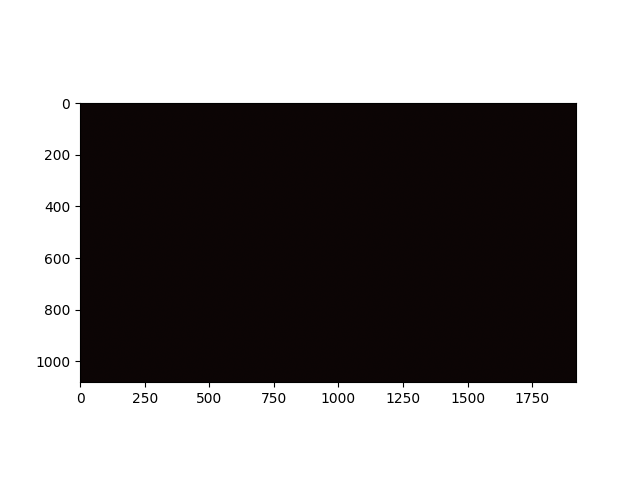

In [212]:

# DIRECTLY ADDED IMAGES
Image_Src_dir = 'Night_camp_images'
Image_files = os.listdir(Image_Src_dir)

DIRECT_ADDITION = np.zeros(cv2.imread(Image_Src_dir+"\\"+Image_files[0]).shape, dtype=np.float_)
IMAGES = []
for file in Image_files:
    IMAGES.append(cv2.imread(Image_Src_dir+"\\"+file)) 
    DIRECT_ADDITION = DIRECT_ADDITION + IMAGES[-1]
DIRECT_ADDITION = DIRECT_ADDITION/(255*len(Image_files))
plt.figure(plot_no)
plot_no += 1
plt.imshow(DIRECT_ADDITION)
plt.show()


# IMAGES AFTER CORRECTION
OUTPUT_IMAGE = np.zeros(cv2.imread(Image_Src_dir+"\\"+Image_files[0]).shape, dtype=np.float_)
for index in range(len(IMAGES)):
    OUTPUT_IMAGE = OUTPUT_IMAGE + cv2.warpAffine(IMAGES[index], np.round(TRANSFORMS[index],8).reshape((2,3)), (IMAGES[0].shape[::-1][1:]))
OUTPUT_IMAGE = OUTPUT_IMAGE/(255*len(IMAGES))
plt.figure(plot_no)
plot_no += 1
plt.imshow(OUTPUT_IMAGE)
plt.show()



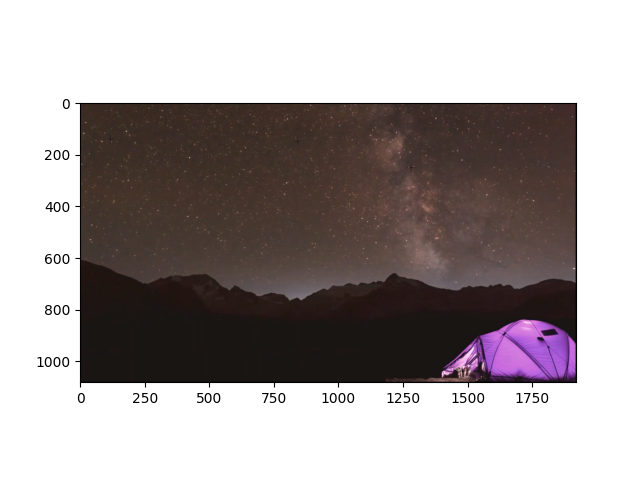

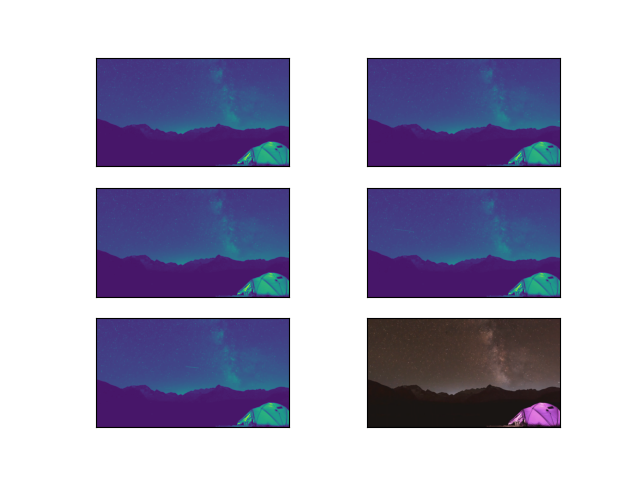

[-1.17916187e+00  5.27838048e-01 -2.22152208e+01 -7.08587708e-01
 -1.58262882e+00  2.03407649e+03]


In [204]:
i=8

Plot_length = 16
image_copy = IMAGES[0].copy()
for star in TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[1][i])]:
    image_copy[max([round(star[0])-Plot_length, 0]) : min([round(star[0])+Plot_length+1, image_copy.shape[0]]),  round(star[1])] = 1
    image_copy[round(star[0]), max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(11)
plt.imshow(image_copy)
plt.show()

Plot_length = 16
image_copy = IMAGES[1].copy()
for star in TRIANGLE_VERTICES[1][i]:
    image_copy[max([round(star[0])-Plot_length, 0]) : min([round(star[0])+Plot_length+1, image_copy.shape[0]]),  round(star[1])] = 1
    image_copy[round(star[0]), max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(12)
plt.imshow(image_copy)
plt.show()


print(transforms[i])

C:\Users\GuruvigneshRajesh\AppData\Local\Temp\ipykernel_11316\4197602428.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(1000)


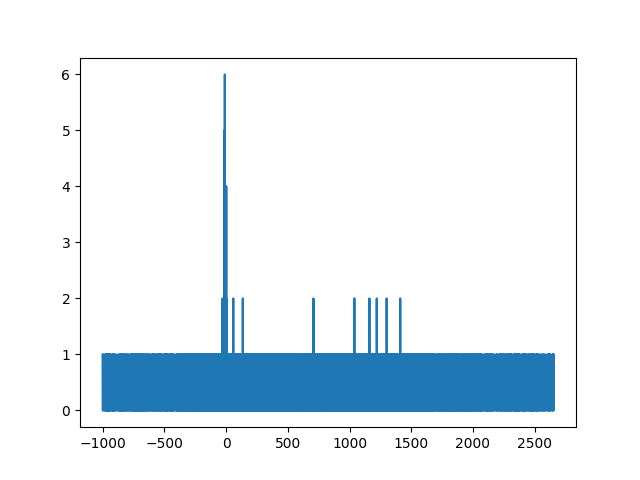

In [210]:
plt.figure(1000)
plt.plot(bins[1:], freq)
plt.show()